$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\Yv}{\mathbf{Y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\betav}{\mathbf{\beta}}
\newcommand{\gv}{\mathbf{g}}
\newcommand{\Hv}{\mathbf{H}}
\newcommand{\dv}{\mathbf{d}}
\newcommand{\Vv}{\mathbf{V}}
\newcommand{\vv}{\mathbf{v}}
\newcommand{\Uv}{\mathbf{U}}
\newcommand{\uv}{\mathbf{u}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\Sv}{\mathbf{S}}
\newcommand{\Gv}{\mathbf{G}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\Zv}{\mathbf{Z}}
\newcommand{\Norm}{\mathcal{N}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}
\newcommand{\dimensionbar}[1]{\underset{#1}{\operatorname{|}}}
\newcommand{\grad}{\mathbf{\nabla}}
\newcommand{\ebx}[1]{e^{\betav_{#1}^T \xv_n}}
\newcommand{\eby}[1]{e^{y_{n,#1}}}
\newcommand{\Tiv}{\mathbf{Ti}}
\newcommand{\Fv}{\mathbf{F}}
\newcommand{\ones}[1]{\mathbf{1}_{#1}}$

# Linear Dimensionality Reduction with Sammon Mapping

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import gzip
import pickle

Introductions to Sammon Mapping are found at
  * [Sammon Mapping in Wikipedia](http://en.wikipedia.org/wiki/Sammon_mapping)
  * [Sammon Mapping](http://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/AV0910/henderson.pdf), by Paul Henderson

A Sammon Mapping is one that maps each data sample $d_i$ to a location in two dimensions, $p_i$, such that distances between pairs of points are preserved. The objective defined by Sammon is to minimize the squared difference in distances between pairs of data points and their projections through the use of an objective function like
$$
\sum_{i=1}^{N-1} \sum_{j=i+1}^N \left (\frac{||d_i - d_j||}{s} - ||p_i - p_j|| \right )^2
$$
The typical Sammon Mapping algorithm does a gradient descent on this function by adjusting all of the two-dimensional points $p_{ij}$.  Each iteration requires computing all pairwise distances.  

One way to decrease this amount of work is to just work with a subset of points, perhaps picked randomly.  To display all points, we just find an explicit mapping (function) that projects a data sample to a two-dimensional point.  Let's call this $f$, so $f(d_i) = p_i$.  For now, let's just use a linear function for $f$, so 
$$
f(d_i) = d_i^T \theta
$$
where $\theta$ is a $D\times 2$ matrix of coefficients. 

To do this in python, let's start with calculating all pairwise distances.  Let $X$ be our $N\times D$ matrix of data samples, one per row.  We can use a list comprehension to calculate the distance between each row in $X$ and each of the rows following that row.

In [2]:
X = np.array([[0, 1], [4, 5], [10, 20]])
X

array([[ 0,  1],
       [ 4,  5],
       [10, 20]])

In [3]:
N = X.shape[0] # number of rows
[(i, j) for i in range(N - 1) for j in range(i + 1, N)]

[(0, 1), (0, 2), (1, 2)]

In [4]:
[X[i, :] - X[j, :] for i in range(N - 1) for j in range(i + 1, N)]

[array([-4, -4]), array([-10, -19]), array([ -6, -15])]

In [5]:
np.array([X[i, :] - X[j, :] for i in range(N - 1) for j in range(i + 1, N)])

array([[ -4,  -4],
       [-10, -19],
       [ -6, -15]])

To convert these differences to distances, just

In [6]:
diffs = np.array([X[i, :] - X[j, :] for i in range(N - 1) for j in range(i + 1 ,N)])
np.sqrt(np.sum(diffs * diffs, axis=1))

array([ 5.65685425, 21.47091055, 16.15549442])

And to project a data point into our two-dimensional space defined by $\theta$, just use matrix multiplication.  Let's make a function to do the projection, and one to convert differences to distances.

In [7]:
def diffToDist(dX):
    return np.sqrt(np.sum(dX * dX, axis=1))

def proj(X, theta):
    return X @ theta

In [8]:
diffToDist(diffs)

array([ 5.65685425, 21.47091055, 16.15549442])

In [9]:
proj(X, np.array([[1 ,0.2], [0.3, 0.8]]))

array([[ 0.3,  0.8],
       [ 5.5,  4.8],
       [16. , 18. ]])

Now, to follow the negative gradient of the objective function, we need its gradient, with respect to $\theta$.  With a little work, you can derive it to find
$$
\begin{align*}
\nabla_\theta &=  \frac{1}{2} \sum_{i=1}^{N-1} \sum_{j=i+1}^N \left (\frac{||d_i - d_j||}{s} - ||p_i - p_j|| \right )^2 \\
 &=  2 \frac{1}{2} \sum_{i=1}^{N-1} \sum_{j=i+1}^N \left (\frac{||d_i - d_j||}{s} - ||f(d_i;\theta) - f(d_j;\theta)|| \right ) (-1) \nabla_\theta ||f(d_i;\theta) - f(d_j;\theta)||\\
  &=  - \sum_{i=1}^{N-1} \sum_{j=i+1}^N \left (\frac{||d_i - d_j||}{s} - ||f(d_i;\theta) - f(d_j;\theta)|| \right )  \frac{(d_i-d_j)^T (p_i - p_j)}{||p_i - p_j||} 
  \end{align*}
$$

So, we need to keep the differences around, in addition to the distances.  First, let's write a function for the objective function, so we can monitor it, to make sure we are decrease it with each iteration.  Let's multiply by $1/N$ so the values we get don't grow huge with large $N$.

In [76]:
def objective(X, proj, theta, s):
    N = X.shape[0]
    P = proj(X, theta)
    dX = np.array([X[i, :] - X[j, :] for i in range(N - 1) for j in range(i + 1, N)])
    dP = np.array([P[i, :] - P[j, :] for i in range(N - 1) for j in range(i + 1, N)])
    return np.sum( (diffToDist(dX) / s - diffToDist(dP))**2) / (N * (N-1) / 2)

Now for the gradient
$$
\begin{align*}
\nabla_\theta &=   - \sum_{i=1}^{N-1} \sum_{j=i+1}^N \left (\frac{||d_i - d_j||}{s} - ||f(d_i;\theta) - f(d_j;\theta)|| \right )  \frac{(d_i-d_j)^T (p_i - p_j)}{||p_i - p_j||}  
  \end{align*}
$$


In [78]:
def gradient(X, proj, theta, s):
    N = X.shape[0]
    P = proj(X, theta)
    dX = np.array([X[i, :] - X[j, :] for i in range(N - 1) for j in range(i + 1, N)])
    dP = np.array([P[i, :] - P[j, :] for i in range(N - 1) for j in range(i + 1, N)])
    distX = diffToDist(dX)
    distP = diffToDist(dP)
    return - ((((distX/s - distP) / distP).reshape((-1,1)) * dX).T @ dP)  / (N * (N - 1) / 2) 

This last line has the potential for dividing by zero!  Let's avoid this, in a very ad-hoc manner, by replacing zeros in *distP* by its smallest nonzero value

In [80]:
def gradient(X, proj, theta, s):
    N = X.shape[0]
    P = proj(X, theta)
    dX = np.array([X[i, :] - X[j, :] for i in range(N - 1) for j in range(i + 1, N)])
    dP = np.array([P[i, :] - P[j, :] for i in range(N - 1) for j in range(i + 1, N)])
    distX = diffToDist(dX)
    distP = diffToDist(dP)
    minimumNonzero = np.min(distP[distP > 0])
    distP[distP == 0] = minimumNonzero
    return - ((((distX/s - distP) / distP).reshape((-1,1)) * dX).T @ dP)  / (N * (N - 1) / 2) 

Let's start with two-dimensional points.

In [81]:
n = 8
X = np.random.multivariate_normal([2, 3], 0.5 * np.eye(2), n)
X = np.vstack((X, np.random.multivariate_normal([1, -1], 0.2 * np.eye(2), n)))
X = X - np.mean(X, axis=0)
s = 0.5 * np.sqrt(np.max(np.var(X, axis=0)))
print('s', s)

s 0.9539667826133666


theta
 [[-0.56175426  0.78870324]
 [-0.8880096  -0.54408489]]


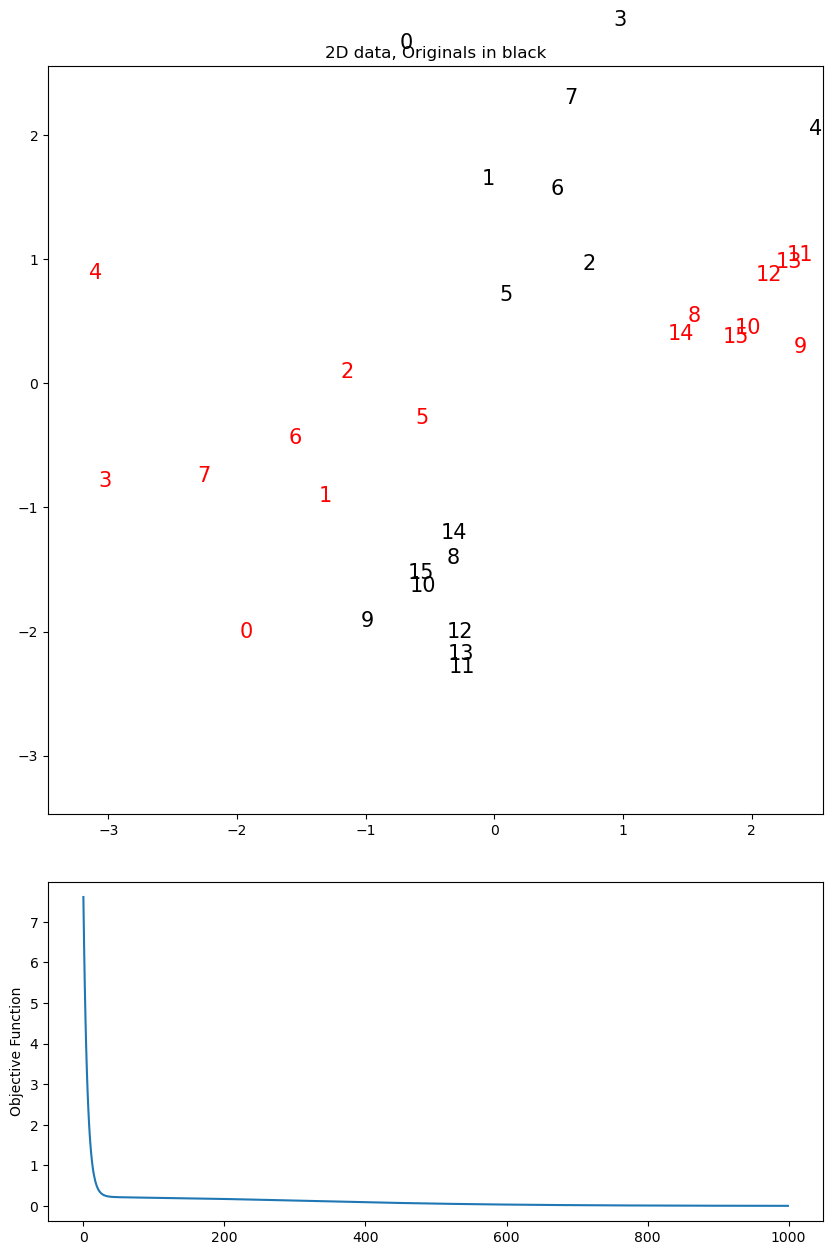

In [84]:
if True:
    theta = np.random.uniform(-0.1, 0.1, (2, 2))
elif False:
    theta = np.eye(2) + np.random.uniform(-0.1,0.1,(2,2))
else:
    u, svalues, v = np.linalg.svd(X)
    v = v.T
    theta = v[:, :2]

nIterations = 1000
vals = []
for i in range(nIterations):
    theta -= 0.01 * gradient(X, proj, theta, s)
    v = objective(X, proj, theta, s)
    vals.append(v)

# print('X\n',X)
# print('P\n',proj(X,theta))
print('theta\n', theta)
plt.figure(figsize=(10, 15))
plt.subplot(3, 1, (1, 2))
P = proj(X, theta)
mn = 1.1 * np.min(P)
mx = 1.1 * np.max(P)
plt.axis([mn, mx, mn, mx])
#strings = [chr(ord('a')+i) for i in range(X.shape[0])]
strings = [i for i in range(X.shape[0])]
for i in range(X.shape[0]):
    plt.text(X[i, 0], X[i, 1], strings[i], color='black', size=15)
for i in range(P.shape[0]):
    plt.text(P[i, 0], P[i, 1], strings[i], color='red', size=15)
plt.title('2D data, Originals in black')

plt.subplot(3, 1, 3)
plt.plot(vals)
plt.ylabel('Objective Function');

Let's watch the mapping develop.  One way to do this is to save the values of $\theta$ after each iteration, then use *interact* to step through the interations.

Check out the [documentation on ipywidgets](https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html)

In [85]:
from ipywidgets import interact

@interact(x=10)
def f(x):
    return x, x**2

interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…

In [87]:
n = 20
X = np.random.multivariate_normal([2, 3], 0.5 * np.eye(2), n)
X = np.vstack((X, np.random.multivariate_normal([1, -1], 0.2 * np.eye(2), n)))
X = X - np.mean(X, axis=0)
s = 0.5 * np.sqrt(np.max(np.var(X, axis=0)))
print('s', s)

if True:
    theta = np.random.uniform(-0.1 , 0.1, (2, 2))
elif False:
    theta = np.eye(2) + np.random.uniform(-0.1, 0.1, (2, 2))
else:
    u, svalues, v = np.linalg.svd(X)
    v = v.T
    theta = v[:, :2]

# theta = (np.random.uniform(size=((2, 2))) - 0.5) * 10

thetas = [theta] # store all theta values

nIterations = 1000
vals = []
for i in range(nIterations):
    theta = theta - 0.05 * gradient(X, proj, theta, s)
    v = objective(X, proj, theta, s)
    thetas.append(theta.copy())
    vals.append(v)


mn = 1.5 * np.min(X)
mx = 1.5 * np.max(X)

strings = [i for i in range(X.shape[0])]

@interact(iteration=(0, nIterations-1, 1))
def plotIteration(iteration):
    #plt.cla()
    plt.figure(figsize=(12, 12));
    theta = thetas[iteration]
    val = vals[iteration]
    P = proj(X, theta)
    plt.axis([mn, mx, mn, mx])
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], strings[i], color='black', size=15) 
    for i in range(P.shape[0]):
        plt.text(P[i, 0], P[i, 1], strings[i], color='red', size=15) 
    plt.title('2D data, Originals in black. Objective={:.3f} Iter={}'.format(val, iteration))

s 1.0372367102626934


interactive(children=(IntSlider(value=499, description='iteration', max=999), Output()), _dom_classes=('widget…

Now let's try it with high-dimensional data. Let's use MNIST digits.

In [88]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1].reshape((-1, 1))

In [98]:
n = 100
X = Xtrain[:n]
T = Ttrain[:n]
X.shape, np.unique(T)

((100, 784), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [100]:
D = 784

if True:
    theta = np.random.uniform(-0.1 , 0.1, (D, 2))
elif False:
    theta = np.eye(2) + np.random.uniform(-0.1, 0.1, (D, 2))
else:
    u, svalues, v = np.linalg.svd(X)
    v = v.T
    theta = v[:, :2]

thetas = [theta] # store all theta values

nIterations = 2000
vals = []
for i in range(nIterations):
    theta = theta - 0.01 * gradient(X, proj, theta, s)
    v = objective(X, proj, theta, s)
    thetas.append(theta.copy())
    vals.append(v)
    if i % 100 == 0:
        print('Done with', i, 'iterations, out of', nIterations)

last_P = proj(X, thetas[-1])
mnx = np.min(last_P[:, 0])
mxx = np.max(last_P[:, 0])
mny = np.min(last_P[:, 1])
mxy = np.max(last_P[:, 1])

@interact(iteration=(0, nIterations-1, 1))
def plotIteration(iteration):
    #plt.cla()
    plt.figure(figsize=(12, 12))
    theta = thetas[iteration]
    val = vals[iteration]
    P = proj(X, theta)
    for i in range(P.shape[0]):
        # plt.text(P[i, 0], P[i, 1], str(T[i, 0]), color='red', size=15) 
        plt.annotate(str(T[i, 0]), P[i], color='red', size=15) 
    plt.axis([mnx, mxx, mny, mxy])
    plt.title('2D data, Originals in black. Objective={:.3f} Iter={}'.format(val, iteration))

Done with 0 iterations, out of 2000
Done with 100 iterations, out of 2000
Done with 200 iterations, out of 2000
Done with 300 iterations, out of 2000
Done with 400 iterations, out of 2000
Done with 500 iterations, out of 2000
Done with 600 iterations, out of 2000
Done with 700 iterations, out of 2000
Done with 800 iterations, out of 2000
Done with 900 iterations, out of 2000
Done with 1000 iterations, out of 2000
Done with 1100 iterations, out of 2000
Done with 1200 iterations, out of 2000
Done with 1300 iterations, out of 2000
Done with 1400 iterations, out of 2000
Done with 1500 iterations, out of 2000
Done with 1600 iterations, out of 2000
Done with 1700 iterations, out of 2000
Done with 1800 iterations, out of 2000
Done with 1900 iterations, out of 2000


interactive(children=(IntSlider(value=999, description='iteration', max=1999), Output()), _dom_classes=('widge…

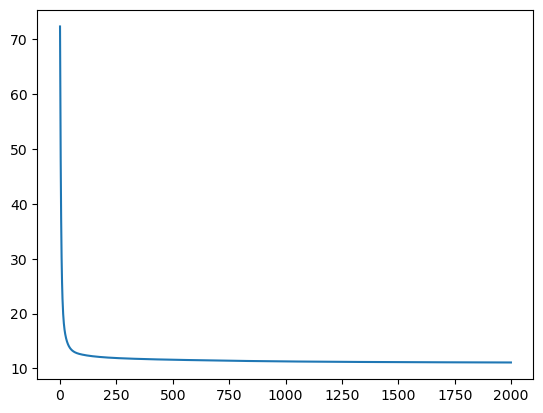

In [101]:
plt.plot(vals)